In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
X_train_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/X_train_1.npy')/255
X_test_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/X_test_1.npy')/255
Y_train_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/Y_train_1.npy')
Y_test_1=np.load(file='C:/Users/haile/OneDrive - University of Bristol/assessment3/DST-assessment-3.1/DST-assessment-3/Zhihui zhang/Y_test_1.npy')

In [3]:

BS = 32
default_image_size = tuple((224,224))
image_size = 0
#directory_root = '/kaggle/input/vegnet-organized-dataset-of-cauliflower-disease'
width=224
height=224
depth=3
n_classes=15

In [4]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

import tensorflow as tf
model = tf.keras.backend.clear_session()
model = None
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
# 创建模型
model = Sequential()

# 第一层卷积层
model.add(Conv2D(filters=64, kernel_size=[3, 3], strides=1, padding="same", activation="relu", input_shape=inputShape))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 第二层卷积层
model.add(Conv2D(filters=128, kernel_size=[3, 3], strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 第三层卷积层
model.add(Conv2D(filters=256, kernel_size=[3, 3], strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 将卷积后的输出拉平为一维向量
model.add(Flatten())

# 全连接层
model.add(Dense(units=1024, activation="relu"))

# 分类层
model.add(Dense(units=n_classes, activation="softmax"))

# 定义优化器和损失函数
optimizer = Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', f1_m,  precision_m, recall_m])

In [20]:
# train the network
print("[INFO] training network...")
history = model.fit(X_train_1, Y_train_1, validation_data=(X_test_1, Y_test_1), epochs=100)


[INFO] training network...
Epoch 1/5
36/74 [=============>................] - ETA: 1:12 - loss: 0.3112 - accuracy: 0.0894 - f1_m: 0.0026 - precision_m: 0.0026 - recall_m: 0.0026

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
    
    epochs = np.arange(1, len(training) + 1)
    
    plt.figure()
    plt.plot(epochs, training, 'bo-', label='Train')
    plt.plot(epochs, validation, 'ro-', label='Val')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    
    filename = 'basic_cnn_{}.png'.format(yaxis)
    plt.savefig(filename)
    print('Figure saved as {}'.format(os.path.abspath(filename)))
    
    plt.show()



Figure saved as c:\Users\haile\OneDrive - University of Bristol\assessment3\DST-assessment-3.1\DST-assessment-3\Zhihui zhang\basic_cnn_accuracy.png


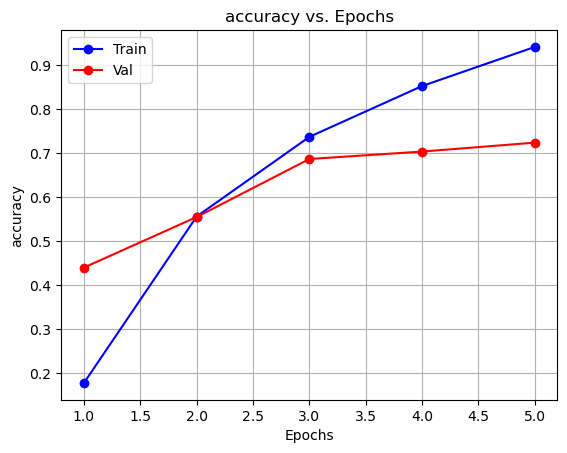

Figure saved as c:\Users\haile\OneDrive - University of Bristol\assessment3\DST-assessment-3.1\DST-assessment-3\Zhihui zhang\basic_cnn_loss.png


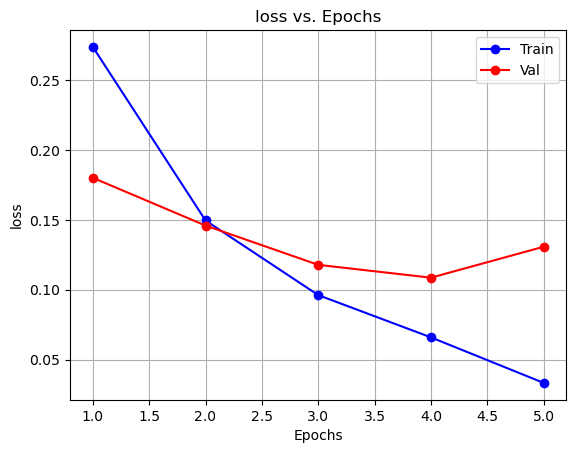

Figure saved as c:\Users\haile\OneDrive - University of Bristol\assessment3\DST-assessment-3.1\DST-assessment-3\Zhihui zhang\basic_cnn_precision.png


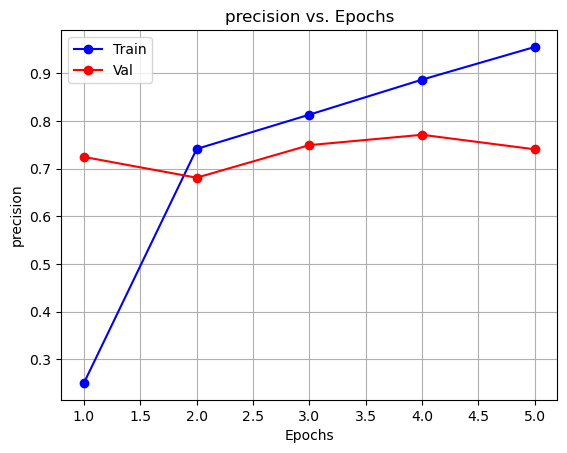

Figure saved as c:\Users\haile\OneDrive - University of Bristol\assessment3\DST-assessment-3.1\DST-assessment-3\Zhihui zhang\basic_cnn_recall.png


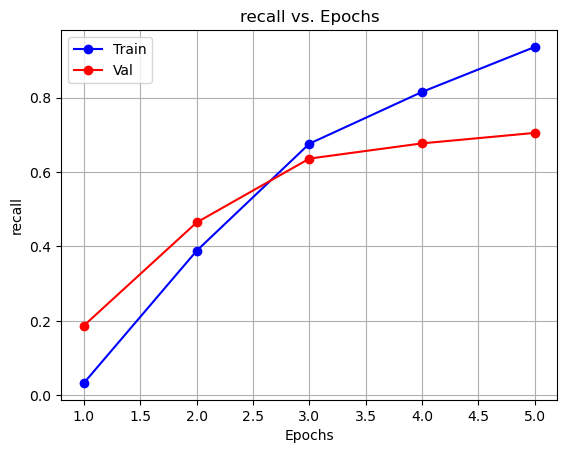

Figure saved as c:\Users\haile\OneDrive - University of Bristol\assessment3\DST-assessment-3.1\DST-assessment-3\Zhihui zhang\basic_cnn_f1 score.png


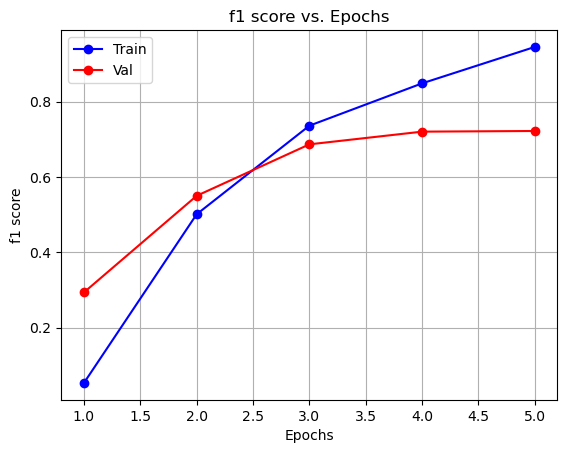

In [ ]:
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy')
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss')
display_training_curves(
    history.history['precision_m'], 
    history.history['val_precision_m'], 
    'precision')
display_training_curves(
    history.history['recall_m'], 
    history.history['val_recall_m'], 
    'recall')
display_training_curves(
    history.history['f1_m'], 
    history.history['val_f1_m'], 
    'f1 score')

In [ ]:
def Res_Plot_Test_Save(name):
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(X_test_1, Y_test_1)
    print(f"Test Accuracy: {scores[1]*100}")
    print("[INFO] Saving model")
    model.save(name)

In [ ]:
Res_Plot_Test_Save('basic.h5')

[INFO] Calculating model accuracy
19/19 [==============================] - 5s 273ms/step - loss: 0.1308 - accuracy: 0.7242 - f1_m: 0.7222 - precision_m: 0.7405 - recall_m: 0.7052
Test Accuracy: 72.41962552070618
[INFO] Saving model


# data augmentation

In [13]:
def train_model(x_train, y_train, x_test, y_test, data_augmentation=False, flip=False, whiten=False):
    if data_augmentation:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                               zoom_range=0.1,
                                                               width_shift_range=0.1,
                                                               height_shift_range=0.1)
        datagen.fit(x_train)
        history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=100,
                            validation_data=(x_test, y_test))
    elif flip:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                               vertical_flip=True)
        datagen.fit(x_train)
        history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=100,
                            validation_data=(x_test, y_test))
    elif whiten:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
                                                               featurewise_std_normalization=True)
        datagen.fit(x_train)
        history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=100,
                            validation_data=(x_test, y_test))
    else:
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=True, # 将输入数据的均值设为0
            featurewise_std_normalization=True, # 将输入数据的标准差设为1
            rotation_range=10, # 随机旋转角度范围
            width_shift_range=0.1, # 随机水平平移
            height_shift_range=0.1, # 随机竖直平移
            horizontal_flip=True, # 随机水平翻转
            vertical_flip=True, # 随机竖直翻转
        )
        datagen.fit(x_train)
        history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                            epochs=100,
                            validation_data=(x_test, y_test))
    return history

# 训练三个模型
history1 = train_model(X_train_1, Y_train_1, X_test_1, Y_test_1, data_augmentation=True)
history2 = train_model(X_train_1, Y_train_1, X_test_1, Y_test_1, flip=True)
history3 = train_model(X_train_1, Y_train_1, X_test_1, Y_test_1, whiten=True)
history4 = train_model(X_train_1, Y_train_1, X_test_1, Y_test_1)



Epoch 1/100


KeyboardInterrupt: 

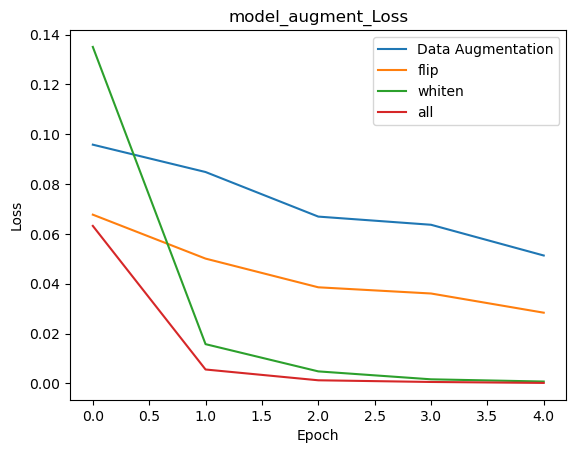

In [ ]:
plt.figure()
plt.plot(history1.history['loss'], label='Data Augmentation')
plt.plot(history2.history['loss'], label='flip')
plt.plot(history3.history['loss'], label='whiten')
plt.plot(history4.history['loss'], label='all')
plt.title('model_augment_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('model_augment_Loss.png')


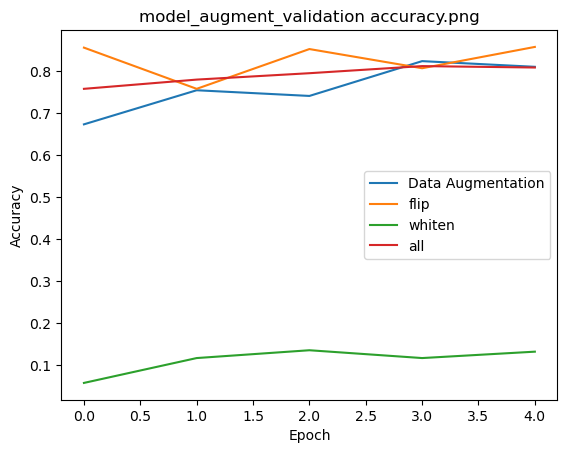

In [ ]:
plt.figure()
plt.plot(history1.history['val_accuracy'], label='Data Augmentation')
plt.plot(history2.history['val_accuracy'], label='flip')
plt.plot(history3.history['val_accuracy'], label='whiten')
plt.plot(history4.history['val_accuracy'], label='all')
plt.title('model_augment_validation accuracy.png')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('model_augment_validation accuracy.png')


# learning rate

In [30]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=True, # 将输入数据的均值设为0
            featurewise_std_normalization=True, # 将输入数据的标准差设为1
            rotation_range=10, # 随机旋转角度范围
            width_shift_range=0.1, # 随机水平平移
            height_shift_range=0.1, # 随机竖直平移
            horizontal_flip=True, # 随机水平翻转
            vertical_flip=True, # 随机竖直翻转
            
            )

model = tf.keras.backend.clear_session()
model = None
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
# 创建模型
model = Sequential()

# 第一层卷积层
model.add(Conv2D(filters=64, kernel_size=[3, 3], strides=1, padding="same", activation="relu", input_shape=inputShape))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 第二层卷积层
model.add(Conv2D(filters=128, kernel_size=[3, 3], strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 第三层卷积层
model.add(Conv2D(filters=256, kernel_size=[3, 3], strides=1, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=[2, 2], strides=2, padding="same"))

# 将卷积后的输出拉平为一维向量
model.add(Flatten())

# 全连接层
model.add(Dense(units=1024, activation="relu"))

# 分类层
model.add(Dense(units=n_classes, activation="softmax"))


In [31]:
# 模型1：使用0.01的学习率训练


def model1():
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 模型2：前10000个batch使用0.01的学习率，10000个batch之后学习率降到0.001
def model2():
    def lr_schedule(epoch=300):
        if epoch < 100:
            return 0.01
        else:
            return 0.001

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 模型3：前10000个batch使用0.01的学习率，10000~20000个batch使用0.001的学习率，20000个batch之后学习率降到0.0005
def model3():
    def lr_schedule(epoch=300):
        if epoch < 100:
            return 0.01
        elif epoch < 200:
            return 0.001
        else:
            return 0.0005
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model




In [32]:
# 构建三个模型
model_1 = model1()
model_2 = model2()
model_3 = model3()

In [33]:
# 训练三个模型
history_1 = model_1.fit(datagen.flow(X_train_1, Y_train_1, batch_size=32), epochs=300, validation_data=(X_test_1,Y_test_1), verbose=0)
history_2 = model_2.fit(datagen.flow(X_train_1, Y_train_1, batch_size=32), epochs=300,validation_data=(X_test_1,Y_test_1), verbose=0)
history_3 = model_3.fit(datagen.flow(X_train_1, Y_train_1, batch_size=32), epochs=300, validation_data=(X_test_1, Y_test_1), verbose=0)



KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(history_1.history['loss'], label='rate 0.01')
plt.plot(history_2.history['loss'], label='rate 0.01+0.001')
plt.plot(history_3.history['loss'], label='rate 0.01+0.001+0.0005')
plt.title('learning rate_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('learning_rate_Loss')


In [ ]:
# 绘制准确率曲线
plt.figure()
plt.plot(history_1.history['val_accuracy'], label='rate 0.01')
plt.plot(history_2.history['val_accuracy'], label='rate 0.01+0.001')
plt.plot(history_3.history['val_accuracy'], label='rate 0.01+0.001+0.0005')
plt.xlabel('Epoch')
plt.ylabel('learning_rate_Accuracy.png')
plt.legend()
plt.show()